## Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from os.path import join
from google.colab.patches import cv2_imshow
from typing import Union, List, Tuple
import scipy.io

## Class definition

In [ ]:
class DynamicEdgeDetection():

  # define variables
  sq_weights : bool

  def __init__(self, sq_weights = False):
    """
    ## Arguments
    - `sq_weights` : we choose either square the weights or not
    """

    self.sq_weights = sq_weights

  def normalize(self, image):
    return image/255.0

  def to_grayscale(self, image):
    if len(image.shape) == 2 :
      return image

    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

  def preprocess(self, image):
    img = image.copy()
    img[img < 0] = -img[img<0]
    return img

  def show_img(self, image, gray=True):
    if gray :
      plt.imshow(image, cmap="gray")
    else :
      plt.imshow(image)

  def compare_figures(self, titles : List, images : List, gray : List):
    assert len(titles) == len(images), "make sure you have as titles as images"

    # Create a figure and subplot axes
    fig, axes = plt.subplots(nrows=1, ncols=len(titles), figsize=(10, 5))
    # Plot each image on a separate subplot
    for i in range(len(titles)):
      if gray[i] :
        axes[i].imshow(images[i], cmap = "gray")
        axes[i].set_title(titles[i])


  def add_padding(self, matrix: np.ndarray,
                  padding: Tuple[int, int]) -> np.ndarray:
      """Adds padding to the matrix.
      Args:
          matrix (np.ndarray): Matrix that needs to be padded. Type is List[List[float]] casted to np.ndarray.
          padding (Tuple[int, int]): Tuple with number of rows and columns to be padded. With the `(r, c)` padding we addding `r` rows to the top and bottom and `c` columns to the left and to the right of the matrix
      Returns:
          np.ndarray: Padded matrix with shape `n + 2 * r, m + 2 * c`.
      """
      n, m = matrix.shape
      r, c = padding

      padded_matrix = np.zeros((n + r * 2, m + c * 2))
      padded_matrix[r : n + r, c : m + c] = matrix

      return padded_matrix


  def _check_params(self, matrix, kernel, stride, dilation, padding):
      params_are_correct = (isinstance(stride[0], int)   and isinstance(stride[1], int)   and
                            isinstance(dilation[0], int) and isinstance(dilation[1], int) and
                            isinstance(padding[0], int)  and isinstance(padding[1], int)  and
                            stride[0]   >= 1 and stride[1]   >= 1 and
                            dilation[0] >= 1 and dilation[1] >= 1 and
                            padding[0]  >= 0 and padding[1]  >= 0)
      assert params_are_correct, 'Parameters should be integers equal or greater than default values.'
      if not isinstance(matrix, np.ndarray):
          matrix = np.array(matrix)
      n, m = matrix.shape
      matrix = matrix if list(padding) == [0, 0] else self.add_padding(matrix, padding)
      n_p, m_p = matrix.shape

      if not isinstance(kernel, np.ndarray):
          kernel = np.array(kernel)
      k = kernel.shape

      kernel_is_correct = k[0] % 2 == 1 and k[1] % 2 == 1
      assert kernel_is_correct, 'Kernel shape should be odd.'
      matrix_to_kernel_is_correct = n_p >= k[0] and m_p >= k[1]
      assert matrix_to_kernel_is_correct, 'Kernel can\'t be bigger than matrix in terms of shape.'

      h_out = np.floor((n + 2 * padding[0] - k[0] - (k[0] - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
      w_out = np.floor((m + 2 * padding[1] - k[1] - (k[1] - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
      out_dimensions_are_correct = h_out > 0 and w_out > 0
      assert out_dimensions_are_correct, 'Can\'t apply input parameters, one of resulting output dimension is non-positive.'

      return matrix, kernel, k, h_out, w_out


  def Conv2D(self, image: Union[List[List[float]], np.ndarray],
              kernel: Union[List[List[float]], np.ndarray],
              stride: Tuple[int, int] = (1, 1),
              dilation: Tuple[int, int] = (1, 1),
              padding: Tuple[int, int] = (0, 0)) -> np.ndarray:
      """Makes a 2D convolution with the kernel over matrix using defined stride, dilation and padding along axes.
      Args:
          image (Union[List[List[float]], np.ndarray]): 2D matrix to be convolved.
          kernel (Union[List[List[float]], np.ndarray]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
          stride (Tuple[int, int], optional): Tuple of the stride along axes. With the `(r, c)` stride we move on `r` pixels along rows and on `c` pixels along columns on each iteration. Defaults to (1, 1).
          dilation (Tuple[int, int], optional): Tuple of the dilation along axes. With the `(r, c)` dilation we distancing adjacent pixels in kernel by `r` along rows and `c` along columns. Defaults to (1, 1).
          padding (Tuple[int, int], optional): Tuple with number of rows and columns to be padded. Defaults to (0, 0).
      Returns:
          np.ndarray: 2D Feature map, i.e. matrix after convolution.
      """
      matrix = image.copy()

      matrix = self.to_grayscale(matrix)
      matrix = self.normalize(matrix)

      matrix, kernel, k, h_out, w_out = self._check_params(matrix, kernel, stride, dilation, padding)
      matrix_out = np.zeros((h_out, w_out))

      b = k[0] // 2, k[1] // 2
      center_x_0 = b[0] * dilation[0]
      center_y_0 = b[1] * dilation[1]
      for i in range(h_out):
          center_x = center_x_0 + i * stride[0]
          indices_x = [center_x + l * dilation[0] for l in range(-b[0], b[0] + 1)]
          for j in range(w_out):
              center_y = center_y_0 + j * stride[1]
              indices_y = [center_y + l * dilation[1] for l in range(-b[1], b[1] + 1)]

              submatrix = matrix[indices_x, :][:, indices_y]

              matrix_out[i][j] = np.sum(np.multiply(submatrix, kernel))
      return self.preprocess(matrix_out)


  def position_assertions(self, image : np.ndarray, position : Union[list, np.ndarray, tuple]):
    assert len(position) == 2, "the position should only contain two coordinates (x, y)"
    assert position[0] > 0 and position[0] < image.shape[1]-1, "make sure 0 < x <image.shape[1]-1 "
    assert position[1] > 0 and position[1] < image.shape[0]-1, "make sure 0 < y <image.shape[0]-1 "
    assert type(position[1]) == int, "make sure your y coordinate is an integer"
    assert type(position[0]) == int, "make sure your x coordinate is an integer"

  def convolve(self, img : np.ndarray, dynamic = True, **kwargs):
    image = img.copy()

    image = self.to_grayscale(image)
    image = self.normalize(image)


    m, n = image.shape
    output = np.zeros_like(image)

    if dynamic :
      for i in range(1, m-1):
        for j in range(1, n-1):

          output[i, j] = self.ponctual_convolution(image, (j, i))
    else :
      assert set(kwargs.keys()).issubset({"kernel", "stride", "dilation", "padding"}), \
      "make sure the arguments are correct and they are subset of {kernel, stride, dilation, padding}"

      output = self.Conv2D(image, kwargs)




    return self.preprocess(output)

  def thresholding(self, image : np.ndarray, threshold : float):
    img = image.copy()
    img[img < threshold] = 0
    img[img >= threshold] = 1

    return img


  def ponctual_convolution(self, image : np.ndarray, position):
    self.position_assertions(image, position)

    x, y = position
    direction = self.direction(image, position)

    w_1 = -np.cos(direction)/np.sqrt(2)+np.sin(direction)/np.sqrt(2)
    w_2 = np.sin(direction)
    w_3 = np.cos(direction)/np.sqrt(2)+np.sin(direction)/np.sqrt(2)
    w_4 = -np.cos(direction)
    w_5 = 0
    w_6 = np.cos(direction)
    w_7 = -np.cos(direction)/np.sqrt(2)-np.sin(direction)/np.sqrt(2)
    w_8 = -np.sin(direction)/np.sqrt(2)
    w_9 = np.cos(direction)/np.sqrt(2)-np.sin(direction)/np.sqrt(2)

    ponct_img = np.array([[image[y-1, x-1], image[y-1, x], image[y-1, x+1]],
                 [image[y, x-1], image[y, x], image[y, x+1]],
                 [image[y+1, x-1], image[y+1, x], image[y+1, x+1]]])

    operator = np.array([w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9]).reshape((3, 3))

    return np.sum(np.sum(operator*ponct_img))

  def get_var_name(self, var):
      """
      Returns the name of a variable as a string.
      """
      for name in globals():
          if globals()[name] is var:
              return name
      for name in locals():
          if locals()[name] is var:
              return name
      return None
  def ods_f(self, img : np.ndarray, bgd_truth : np.ndarray):
    TP = np.asarray([img[img == 1] == bgd_truth[bgd_truth == 1]]).sum()
    TN = np.asarray([img[img == 0] == bgd_truth[bgd_truth == 0]]).sum()
    FP = np.asarray([img[img == 1] == bgd_truth[bgd_truth == 0]]).sum()
    FN = np.asarray([img[img == 0] == bgd_truth[bgd_truth == 1]]).sum()

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2/(1/precision+1/recall)

    return F1

  def get_var_value(self, var_name, namespace=locals()):
      """
      Returns the value of a variable given its name as a string.
      """
      if namespace is None:
          namespace = globals()
      try:
          return namespace[var_name]
      except KeyError:
          raise ValueError("Variable not found.")

  def sobel(self, img, to_sum=None, all_directions = True):

    image = img.copy()
    image = self.to_grayscale(image)
    image = self.normalize(image)

    filters = {
        "sobel_v" : np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]),

    "sobel_h" : np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ]),


    "sobel_d" : np.array([
        [2, 1, 0],
        [1, 0, -1],
        [0, -1, -2]
    ]),


    "sobel_id" : np.array([
        [0, 1, 2],
        [-1, 0, 1],
        [-2, -1, 0]
    ]),

    }

    output = np.zeros(image.shape)

    if(all_directions):
      to_sum = ["sobel_v", "sobel_h", "sobel_d", "sobel_id"]

    kernel = np.zeros((3, 3))
    for f in to_sum :
      kernel += filters[f]

    output = self.Conv2D(image, kernel=kernel, padding = (1, 1))

    return self.preprocess(output)


  def direction(self, image : np.ndarray, position : Union[list, np.ndarray, tuple]):
    self.position_assertions(image, position)

    def get_direction(num, den):
      if num == 0 and den == 0:
        return 0
      elif den == 0:
        return np.arctan(np.inf)
      else :
        return np.arctan(num/den)


    x, y = position

    # calculate portions
    direction = get_direction(image[y-1, x]-image[y, x], image[y, x+1]-image[y, x])

    return direction

  def mat_to_ndarray_image(self, mat_file_path, content = "groundTruth"):
      try:
          # Load the .mat file
          mat_data = scipy.io.loadmat(mat_file_path)

          # Assuming the variable name in the .mat file is 'image'
          image_data = mat_data[content]

          # Convert the MATLAB matrix to a NumPy ndarray
          image_ndarray = np.array(image_data)

          return image_ndarray
      except Exception as e:
          print("An error occurred:", str(e))
          return None


## Test

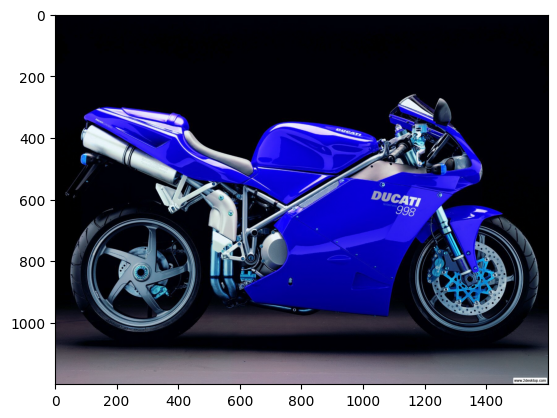

In [ ]:
ASSETS_PATH = "/content/drive/MyDrive/Research Projects/1. Edge detection/paper/figures/test"
img = cv.imread(join(ASSETS_PATH, "bike1.jpg"))
plt.imshow(img)

In [ ]:
ded = DynamicEdgeDetection()
len(ded.mat_to_ndarray_image(join(ASSETS_PATH, "100007.mat"))[0, 1][0][0])

(array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

In [ ]:
dynamic = ded.convolve(img)

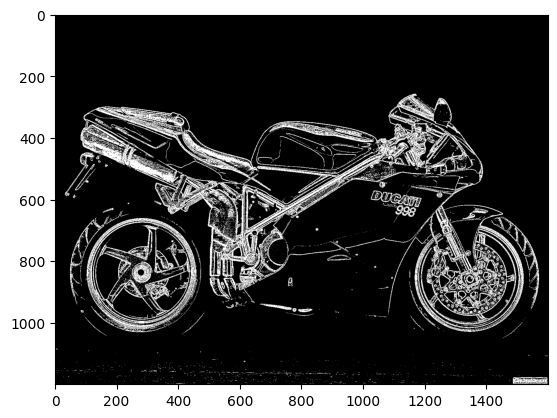

In [ ]:
ded.show_img(ded.thresholding(dynamic, 0.2))

In [ ]:
sob = ded.sobel(img)

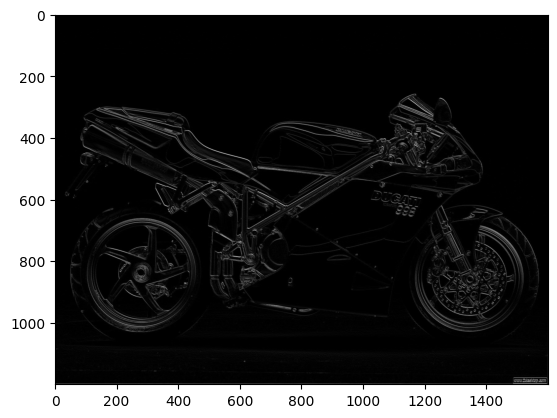

In [ ]:
ded.show_img(sob)

In [ ]:
print(np.sum(np.sum(dynamic)))
print(np.sum(np.sum(sob)))

165007.7321656166
1992.4789542483657


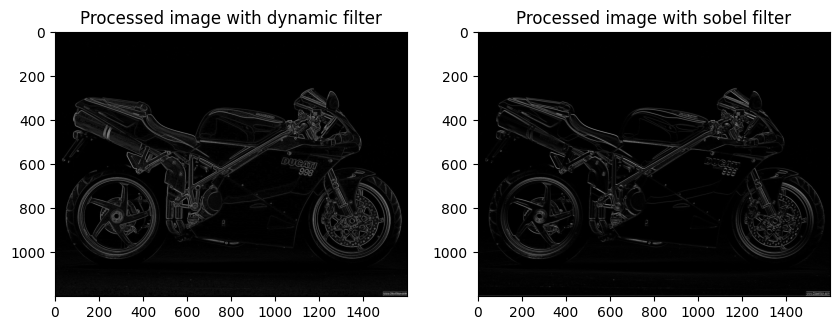

In [ ]:
ded.compare_figures(["Processed image with dynamic filter", "Processed image with sobel filter"],
                    [dynamic, sob], [True, True])